In [1]:
from __future__ import print_function, division
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


import os


Preprocess environment so :
* Image resized to 42x42 and grayscale to run faster
* Divides rewards by 100
* Agent sees last 4 frames of game to account for object velocity (POMDP --> MDP)

In [2]:
import gym
from atari_util import PreprocessAtari

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(env, height=42, width=42,
                          crop = lambda img: img[60:-30, 5:],
                          dim_order = 'tensorflow',
                          color=False, n_frames=4,
                          reward_scale = 0.01)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (42, 42, 4)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']
Observation shape: (42, 42, 4)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


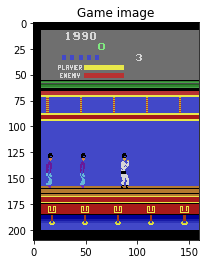

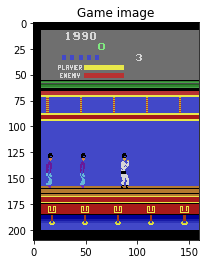

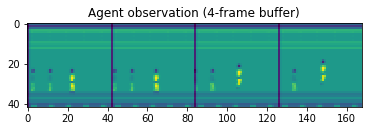

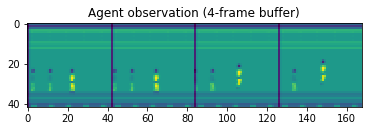

In [3]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0,2,1]).reshape([42,-1]))
plt.show()

In [4]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [5]:
Dense = tf.keras.layers.Dense
Conv2D = tf.keras.layers.Conv2D
Flatten = tf.keras.layers.Flatten
Input = tf.keras.layers.Input
Model = tf.keras.models.Model

class Agent:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        
        with tf.variable_scope(name, reuse=reuse):
            
            inputs = Input(shape=state_shape)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(inputs)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x = Flatten()(x)
            x = Dense(128, activation='relu')(x)
            
            # two different output layers
            logits = Dense(n_actions, activation='linear')(x)
            state_value = Dense(1, activation='linear')(x)
            
            self.network = Model(inputs=inputs, outputs=[logits, state_value])
            
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)
        
    def symbolic_step(self, state_t):
        
        logits, state_value = self.network(state_t)
        state_value = tf.squeeze(state_value)

        return (logits, state_value)
    
    def step(self, state_t):
        """if state is numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [6]:
agent = Agent("agent", obs_shape, n_actions)
sess.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.


In [7]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[ 0.01273285 -0.01609421  0.01940087  0.02012752 -0.00730079  0.01154098
   0.0392706  -0.01845368  0.01984154 -0.07565097 -0.04682587 -0.02125068
  -0.0354757   0.04669335]]
state values:
 0.013698808
action logits:
 [[ 0.01273285 -0.01609421  0.01940087  0.02012752 -0.00730079  0.01154098
   0.0392706  -0.01845368  0.01984154 -0.07565097 -0.04682587 -0.02125068
  -0.0354757   0.04669335]]
state values:
 0.013698808


### Let's play!
Let's build a function that measures agent's average reward.

In [8]:
def evaluate(agent, env, n_games=1):
    """Returns total rewards from a rollout """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        
        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done: break
                
        game_rewards.append(total_reward)
    return game_rewards


In [9]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print (rw)

[5.0, 7.0, 2.0]
[5.0, 7.0, 2.0]


In [10]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[0])) #this may or may not be _last_ video. Try other indices



### Training on parallel games

Train on n_envs parallel environments

In [11]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

__Let's try it out:__

In [12]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()

batch_actions = agent.sample_actions(agent.step(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions[:3])
print("Rewards:", batch_rewards[:3])
print("Done:", batch_done[:3])


State shape: (10, 42, 42, 4)
Actions: [1 3 7]
Rewards: [0. 0. 0.]
Done: [False False False]
State shape: (10, 42, 42, 4)
Actions: [1 3 7]
Rewards: [0. 0. 0.]
Done: [False False False]


# Actor-critic

Here we define a loss functions and learning algorithms as usual.

In [13]:
states_ph = tf.placeholder('float32', [None,] + list(obs_shape))    
next_states_ph = tf.placeholder('float32', [None,] + list(obs_shape))
actions_ph = tf.placeholder('int32', (None,))
rewards_ph = tf.placeholder('float32', (None,))
is_done_ph = tf.placeholder('float32', (None,))

In [14]:
# logits[n_envs, n_actions] and state_values[n_envs, n_actions]
logits, state_values = agent.symbolic_step(states_ph)
next_logits, next_state_values = agent.symbolic_step(next_states_ph)
next_state_values = next_state_values * (1 - is_done_ph) #terminal states have no value

# probabilities and log-probabilities for all actions
probs = tf.nn.softmax(logits)            # [n_envs, n_actions]
logprobs = tf.nn.log_softmax(logits)     # [n_envs, n_actions]

# log-probabilities only for agent's chosen actions
logp_actions = tf.reduce_sum(logprobs * tf.one_hot(actions_ph, n_actions), axis=-1) 

In [ ]:
print(f"probs :{probs}")
print(f"logprobs :{logprobs}")
print(f"logp_actions :{logp_actions}")

In [15]:
# compute advantage using rewards_ph, state_values and next_state_values
gamma = 0.99
advantage = rewards_ph + gamma*next_state_values - state_values

# compute policy entropy given logits_seq. Mind the "-" sign!
entropy =  -tf.reduce_sum(probs * logprobs, 1, name="entropy")
actor_loss =  - tf.reduce_mean(logp_actions * tf.stop_gradient(advantage)) - 0.001 * tf.reduce_mean(entropy)

# compute target state values using temporal difference formula. Use rewards_ph and next_step_values
target_state_values = rewards_ph+gamma*next_state_values

critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2 )

train_step = tf.train.AdamOptimizer(1e-4).minimize(actor_loss + critic_loss)
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


## Train  the network


In [2]:
from IPython.display import clear_output
from tqdm import trange
import pandas as pd
env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

NameError: name 'EnvBatch' is not defined

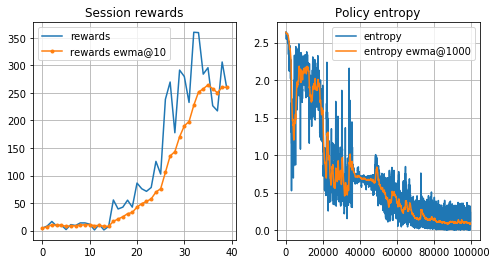

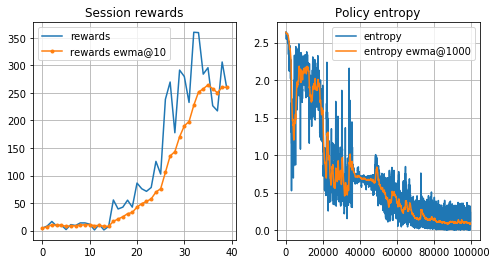

100%|██████████| 100000/100000 [36:30<00:00, 45.65it/s]


In [18]:
for i in trange(int(10e5)): 
    
    batch_actions = agent.sample_actions(agent.step(batch_states))
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
    
    feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_next_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    }
    batch_states = batch_next_states
    
    _, ent_t = sess.run([train_step, entropy], feed_dict)
    entropy_history.append(np.mean(ent_t))

    if i % 500 == 0: 
        if i % 2500 == 0:
            rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))


        clear_output(True)
        plt.figure(figsize=[8,4])
        plt.subplot(1,2,1)
        plt.plot(rewards_history, label='rewards')
        plt.plot(pd.DataFrame(np.array(rewards_history)).ewm(span=10).mean(), marker='.', label='rewards ewma@10')        
        plt.title("Session rewards"); plt.grid(); plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(entropy_history, label='entropy')
        plt.plot(pd.DataFrame(np.array(entropy_history)).ewm(span=1000).mean(), label='entropy ewma@1000')
        plt.title("Policy entropy"); plt.grid(); plt.legend()        
        plt.show()
        
        



### "Final" evaluation

In [19]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=1,)
env_monitor.close()
print("Final mean reward:", np.mean(final_rewards))

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

Final mean reward: 314.0
Final mean reward: 314.0


In [6]:
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1])) 

```

```
```

```
```

```
```

```
```

```
```

```
```

```
```

```
